In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import random
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences

In [3]:
jokes_csv = pd.read_csv('./shortjokes.csv') # dataset https://www.kaggle.com/abhinavmoudgil95/short-jokes

In [4]:
jokes= jokes_csv.iloc[:50000] #I cut the number of jokes because it takes the model too long to train

In [5]:
# overload dataset
class JokesDataset(Dataset):
    def __init__(self, csv, tokenizer, max_len):
        super().__init__()
        self.csv = csv
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        # we add 'JOKE' so that the model knows what the joke is, and the final token so that the model knows when to stop
        joke_str = 'JOKE:' + self.csv.Joke.values[index] + self.tokenizer.eos_token 
        joke_tokenized = tokenizer.encode(joke_str)
        #ensure lengths
        if (len(joke_tokenized) < self.max_len):
            attention_mask = [1 for i in range(len(joke_tokenized))] + [0 for i in range((self.max_len - len(joke_tokenized)))]
            joke_tokenized += [0] * (self.max_len - len(joke_tokenized))
        elif (len(joke_tokenized) > self.max_len):
            joke_tokenized = joke_tokenized[:self.max_len - 1] + tokenizer.encode(self.tokenizer.eos_token)
            attention_mask = [1 for i in range(self.max_len)]

        joke_tokenized = torch.LongTensor(joke_tokenized)
        attention_mask = torch.LongTensor(attention_mask)
        return joke_tokenized, attention_mask

    def __len__(self):
        return len(self.csv)

In [6]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')

In [7]:
joke_dataset = JokesDataset(jokes, tokenizer, 100)
joke_dataloader = DataLoader(joke_dataset, batch_size=16, shuffle=True)

In [8]:
N_EPOCHS = 1
device = torch.device('cuda')
model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

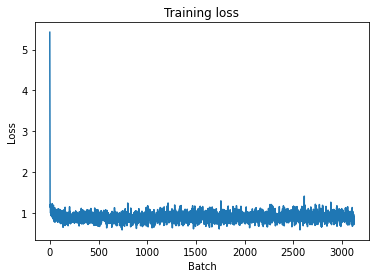

In [9]:
# training
model.train()
best_loss = float('inf')
from IPython.display import clear_output
train_loss_history = []
for i in range(N_EPOCHS):
    for joke, attn in joke_dataloader:
        joke = joke.to(device)
        attn = attn.to(device)
        outputs = model(joke, attention_mask = attn, labels=joke)
        loss, logits = outputs[:2]
        loss.backward()
        optimizer.step()
        loss_value = loss.detach().cpu()
        train_loss_history.append(loss_value)
        clear_output(True)
        plt.plot(train_loss_history)
        plt.title("Training loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()
torch.save(model.state_dict(),'./model.pt')

We can generate the most possible word, but this can lead to bad results (circularity for example), so we can use BeamSearch, this is a truncated version of the BruteForce.

In [10]:
import heapq

In [11]:
class BeamGenerator:
    def __init__(self, model, tokenizer, device = 'cuda', eos_token_id = 0):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.model.to(self.device)
        self.eos_token_id = eos_token_id
        
    def __call__(self, seed_text, max_steps_n = 100, return_hypotheses_n = 5, beamsize = 5):
        seed_tokens = self.tokenizer.encode(seed_text)
        initial_length = len(seed_tokens)
        partial_hypotheses = [(0, seed_tokens)]
        final_hypotheses = []
        
        while len(partial_hypotheses) > 0:
            cur_partial_score, cur_partial_hypothesis = heapq.heappop(partial_hypotheses)
            
            in_batch = torch.tensor(cur_partial_hypothesis).to(self.device)
            outputs = self.model(in_batch, labels=in_batch)
            loss, logits = outputs[:2]
            next_tokens_logits = logits[-1]
            next_tokens_logproba = torch.nn.functional.log_softmax(next_tokens_logits)
            topk_continuations = next_tokens_logproba.topk(beamsize)
            
            for token_score, token_idx in zip(topk_continuations.values, topk_continuations.indices):
                token_score = float(token_score)
                token_idx = int(token_idx)
                
                old_denorm_score = cur_partial_score * np.sqrt(len(cur_partial_hypothesis))
                new_score = (old_denorm_score - token_score) / np.sqrt(len(cur_partial_hypothesis) + 1)
                
                new_hypothesis = cur_partial_hypothesis + [token_idx]
                new_item = (new_score, new_hypothesis)
                
                if token_idx == self.eos_token_id or len(new_hypothesis) - initial_length >= max_steps_n:
                    final_hypotheses.append(new_item)
                else:
                    heapq.heappush(partial_hypotheses, new_item)
                    
            if len(partial_hypotheses) > beamsize:
                partial_hypotheses = heapq.nsmallest(beamsize, partial_hypotheses)
                heapq.heapify(partial_hypotheses)

        final_hypotheses.sort()
        final_hypotheses = final_hypotheses[:return_hypotheses_n]
        result = []
        for score, hyp in final_hypotheses:
            result.append((score, tokenizer.decode(hyp)))
        return result

In [12]:
model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
model.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>

In [27]:
model.eval()
beam_search = BeamGenerator(model, tokenizer, eos_token_id=tokenizer.eos_token_id)
beam_search('JOKE:One man')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[(1.8794059697538614,
  'JOKE:One man walks into a bar... The other man ducks.<|endoftext|>'),
 (2.192127040314611,
  'JOKE:One man walks into a bar... And the other man ducks.<|endoftext|>'),
 (2.3859195935540525,
  'JOKE:One man walks into a bar... The other man ducks. The first man ducks.<|endoftext|>'),
 (2.4208162696333786,
  'JOKE:One man walks into a bar... The other man ducks<|endoftext|>'),
 (2.4782742604709926,
  'JOKE:One man walks into a bar... The other man ducks. The first man ducks. The second man ducks.<|endoftext|>')]

Ok, very strange jokes. Let's try another approach. On every prediction choose random word from topk.

In [28]:
def choose_from_top(probs, n=5):
    ind = np.argpartition(probs, -n)[-n:] #take top n probs
    top_prob = probs[ind]
    top_prob = top_prob / np.sum(top_prob) # Normalize
    choice = np.random.choice(n, 1, p = top_prob) #pick one of top n words with probs = top_prob
    token_id = ind[choice][0] #get token_id
    return int(token_id)

def generate_some_text(input_str, text_len = 250):
    inputs = torch.LongTensor(tokenizer.encode(input_str)).to(device)
    model.eval()
    with torch.no_grad():
        for i in range(text_len):
            outputs = model(inputs, labels=inputs)
            loss, logits = outputs[:2]
            softmax_logits = torch.softmax(logits[-1], dim=0)
            next_token_id = choose_from_top(softmax_logits.cpu().numpy(), n=10)
            if ([next_token_id] == tokenizer.encode(tokenizer.eos_token)): # if the network generated the end of the sentence, stop 
                break
            inputs = torch.LongTensor(inputs.cpu().tolist() + [next_token_id]).to(device)

        output_text = tokenizer.decode(inputs)
        print(output_text)

In [29]:
generate_some_text('JOKE:One man')

JOKE:One man was walking down the hill.. and said to the other, "Hey man, are you the hill, the rope?" "No," the other replies, "It's a joke."


OK, this is more of a joke. I think the problem with ray search is that in fact, in this situation, since there was not very much data, and a lot of jokes start with the phrase "One man goes to a bar", the model goes "on a rolling track". But if we choose a random word, we give the model some variation